<a href="https://colab.research.google.com/github/jumarinr/trabajo-tae-4/blob/main/Trabajo_4_TAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Competencia de modelos de Predicción para el número de vehículos registrados

## Importación de librerías

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.metrics import r2_score
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

!pip install holidays_co
from holidays_co import is_holiday_date

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Lectura de datos

In [ ]:
#Simples permisos para leer desde drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#Link del csv con nuestros datos
cars = 'https://docs.google.com/spreadsheets/d/12hqhpFo5kl79TwExomOs3RYyBnyezRT5/edit'
 
# to get the id part of the file
id = cars.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('registros_autos_entrenamiento.xlsx') 
df = pd.read_excel('registros_autos_entrenamiento.xlsx')

In [ ]:
df

,Fecha,Unidades
0,2012-01-01,0.0
1,2012-01-02,188.0
2,2012-01-03,482.0
3,2012-01-04,927.0
4,2012-01-05,1159.0
...,...,...
2187,2017-12-27,2102.0
2188,2017-12-28,3449.0
2189,2017-12-29,1084.0
2190,2017-12-30,18.0


## Ingeniería de características

Como se puede apreciar, los datos leídos están compuestos por dos columnas: Fecha y Unidades. 

+ Fecha: fecha en la que se registraron cierta cantidad de autos en el RUNT.
+ Unidades: cantidad de vehículos registrados en el RUNT.

Estas fechas guardan información de forma implícita y, por medio de ingeniería de características, esa información será extraída.


Se definen las funciones que permitirán extraer la información de las fechas.

+ Get_day: devuelve el día del mes.
+ Get_weekday: devuelve el día de la semana (Lunes, Martes, Miércoles, Jueves, Viernes, Sábado o Domingo).
+ Get_year: devuelve el año.
+ Get_month: devuelve el mes.
+ Get_dayofyear: devuelve el día en el año.
+ Get_weekofyear: devuelve la semana del año.
+ Is_weekend: devuelve si es fin de semana o no.
+ Is_startofmonth: devuelve si es el inicio del mes.
+ Is_endofmonth: devuelve si es fin de mes.
+ Is_startofyear: devuelve si es el inicio del año.
+ Is_endofyear: devuelve si es fin de año.

Estas funciones se aplican en una función mayor llamada "database", la cual construye la base de datos con base en la fecha para utilizarla en los modelos de predicción.

Esta tabla define el valor para cada día de la semana.

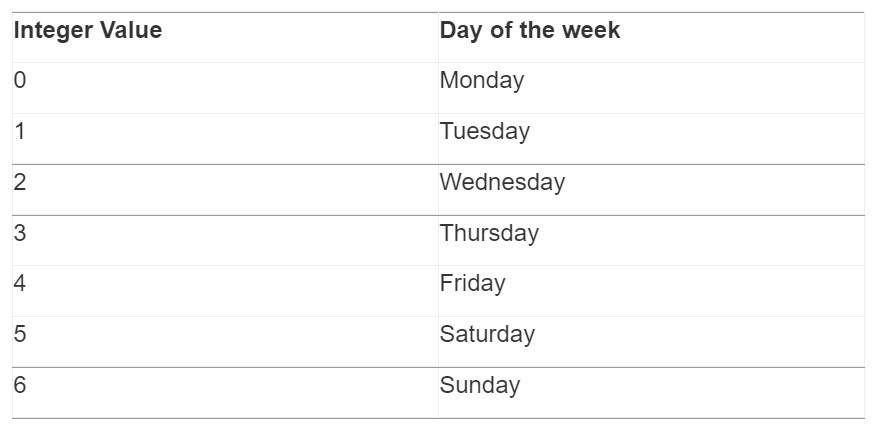

In [ ]:
# function to get all data from time stamp
 
# get date
def get_day(dt):
    return dt.day
 
# get week day
def get_weekday(dt):
    return dt.weekday()
 
# get year
def get_year(dt):
    return dt.year
 
# get month
def get_month(dt):
    return dt.month
 
# get year day
def get_dayofyear(dt):
    return dt.dayofyear
 
# get year week
def get_weekofyear(dt):
    return dt.weekofyear

# verify if its weekend
def is_weekend(day):
  return np.where(day in ([5,6]), 1,0)

# verify if it's start of month
def is_startofmonth(dt):
  return 1 if dt.is_month_start else 0

# verify if it's end of month
def is_endofmonth(dt):
  return 1 if dt.is_month_end else 0

# verify if it's start of year
def is_startofyear(dt):
  return 1 if dt.is_year_start else 0

# verify if it's end of year
def is_endofyear(dt):
  return 1 if dt.is_year_end else 0

def database(df):
  df['Fecha'] = df['Fecha'].map(pd.to_datetime)
  df['Dia'] = df['Fecha'].map(get_day)
  df['Dia_Semana'] = df['Fecha'].map(get_weekday)
  df['Fin_Semana'] = df['Dia_Semana'].map(is_weekend)
  df['Mes'] = df['Fecha'].map(get_month)
  df['Inicio_Mes'] = df['Fecha'].map(is_startofmonth)
  df['Fin_Mes'] = df['Fecha'].map(is_endofmonth)
  df['Anio'] = df['Fecha'].map(get_year)
  df['Inicio_Anio'] = df['Fecha'].map(is_startofyear)
  df['Fin_Anio'] = df['Fecha'].map(is_endofyear)
  df['Dia_Anio'] = df['Fecha'].map(get_dayofyear)
  df['Semana_Anio'] = df['Fecha'].map(get_weekofyear)
  df['Festivo'] = df.Fecha.apply(lambda fecha: 1 if is_holiday_date(fecha.date()) else 0)
  return df

database(df)

,Fecha,Unidades,Dia,Dia_Semana,Fin_Semana,Mes,Inicio_Mes,Fin_Mes,Anio,Inicio_Anio,Fin_Anio,Dia_Anio,Semana_Anio,Festivo
0,2012-01-01,0.0,1,6,1,1,1,0,2012,1,0,1,52,1
1,2012-01-02,188.0,2,0,0,1,0,0,2012,0,0,2,1,0
2,2012-01-03,482.0,3,1,0,1,0,0,2012,0,0,3,1,0
3,2012-01-04,927.0,4,2,0,1,0,0,2012,0,0,4,1,0
4,2012-01-05,1159.0,5,3,0,1,0,0,2012,0,0,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,2017-12-27,2102.0,27,2,0,12,0,0,2017,0,0,361,52,0
2188,2017-12-28,3449.0,28,3,0,12,0,0,2017,0,0,362,52,0
2189,2017-12-29,1084.0,29,4,0,12,0,0,2017,0,0,363,52,0
2190,2017-12-30,18.0,30,5,1,12,0,0,2017,0,0,364,52,0


Al construir la base de datos para los modelos, se obtiene lo siguiente:

In [ ]:
df.head()

,Fecha,Unidades,Dia,Dia_Semana,Fin_Semana,Mes,Inicio_Mes,Fin_Mes,Anio,Inicio_Anio,Fin_Anio,Dia_Anio,Semana_Anio,Festivo
0,2012-01-01,0.0,1,6,1,1,1,0,2012,1,0,1,52,1
1,2012-01-02,188.0,2,0,0,1,0,0,2012,0,0,2,1,0
2,2012-01-03,482.0,3,1,0,1,0,0,2012,0,0,3,1,0
3,2012-01-04,927.0,4,2,0,1,0,0,2012,0,0,4,1,0
4,2012-01-05,1159.0,5,3,0,1,0,0,2012,0,0,5,1,0


Después, se construye la base de datos con las fechas del primer semestre del 2018. Esta base de datos será utilizada para realizar predicciones respecto a la posible cantidad de registros de vehículos en ese entonces.

In [ ]:
inicio_2018 = dt.date(2018,1,1)
fin_2018 = dt.date(2018,7,1)
df_2018 = pd.DataFrame({'Fecha': pd.date_range(inicio_2018, fin_2018-dt.timedelta(days=1),freq='d')})
df_2018 = database(df_2018)
df_2018

,Fecha,Dia,Dia_Semana,Fin_Semana,Mes,Inicio_Mes,Fin_Mes,Anio,Inicio_Anio,Fin_Anio,Dia_Anio,Semana_Anio,Festivo
0,2018-01-01,1,0,0,1,1,0,2018,1,0,1,1,1
1,2018-01-02,2,1,0,1,0,0,2018,0,0,2,1,0
2,2018-01-03,3,2,0,1,0,0,2018,0,0,3,1,0
3,2018-01-04,4,3,0,1,0,0,2018,0,0,4,1,0
4,2018-01-05,5,4,0,1,0,0,2018,0,0,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,2018-06-26,26,1,0,6,0,0,2018,0,0,177,26,0
177,2018-06-27,27,2,0,6,0,0,2018,0,0,178,26,0
178,2018-06-28,28,3,0,6,0,0,2018,0,0,179,26,0
179,2018-06-29,29,4,0,6,0,0,2018,0,0,180,26,0


Se eliminan las fechas de la base de datos del 2018 debido a que ya no es relevante.

In [ ]:
predict_2018 = df_2018.drop(['Fecha'], axis=1)
predict_2018

,Dia,Dia_Semana,Fin_Semana,Mes,Inicio_Mes,Fin_Mes,Anio,Inicio_Anio,Fin_Anio,Dia_Anio,Semana_Anio,Festivo
0,1,0,0,1,1,0,2018,1,0,1,1,1
1,2,1,0,1,0,0,2018,0,0,2,1,0
2,3,2,0,1,0,0,2018,0,0,3,1,0
3,4,3,0,1,0,0,2018,0,0,4,1,0
4,5,4,0,1,0,0,2018,0,0,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
176,26,1,0,6,0,0,2018,0,0,177,26,0
177,27,2,0,6,0,0,2018,0,0,178,26,0
178,28,3,0,6,0,0,2018,0,0,179,26,0
179,29,4,0,6,0,0,2018,0,0,180,26,0


## División de base de datos entre entrenamiento y validación

Ahora, se extraen los datos a usar para entrenamiento y para validation.

+ Training: desde 01/01/2012 hasta 31/12/2016.
+ Validation: desde 01/01/2017 hasta 31/12/2017.

Luego se separan las unidades para tener los valores objetivo con los que compararemos lso modelos.

In [ ]:
df_training = df[df['Anio'] <= 2016].drop(['Fecha'], axis=1)
training = df_training.drop(['Unidades'], axis=1)
training_target = df_training['Unidades']
print(training)
training_target

      Dia  Dia_Semana  Fin_Semana  Mes  Inicio_Mes  Fin_Mes  Anio  \
0       1           6           1    1           1        0  2012   
1       2           0           0    1           0        0  2012   
2       3           1           0    1           0        0  2012   
3       4           2           0    1           0        0  2012   
4       5           3           0    1           0        0  2012   
...   ...         ...         ...  ...         ...      ...   ...   
1822   27           1           0   12           0        0  2016   
1823   28           2           0   12           0        0  2016   
1824   29           3           0   12           0        0  2016   
1825   30           4           0   12           0        0  2016   
1826   31           5           1   12           0        1  2016   

      Inicio_Anio  Fin_Anio  Dia_Anio  Semana_Anio  Festivo  
0               1         0         1           52        1  
1               0         0         2          

0          0.0
1        188.0
2        482.0
3        927.0
4       1159.0
         ...  
1822    1922.0
1823    2409.0
1824    3603.0
1825     965.0
1826      46.0
Name: Unidades, Length: 1827, dtype: float64

In [ ]:
df_validation = df[df['Anio'] == 2017].drop(['Fecha'], axis=1)
validation = df_validation.drop(['Unidades'], axis=1)
validation_target = df_validation['Unidades']
print(validation)
validation_target

      Dia  Dia_Semana  Fin_Semana  Mes  Inicio_Mes  Fin_Mes  Anio  \
1827    1           6           1    1           1        0  2017   
1828    2           0           0    1           0        0  2017   
1829    3           1           0    1           0        0  2017   
1830    4           2           0    1           0        0  2017   
1831    5           3           0    1           0        0  2017   
...   ...         ...         ...  ...         ...      ...   ...   
2187   27           2           0   12           0        0  2017   
2188   28           3           0   12           0        0  2017   
2189   29           4           0   12           0        0  2017   
2190   30           5           1   12           0        0  2017   
2191   31           6           1   12           0        1  2017   

      Inicio_Anio  Fin_Anio  Dia_Anio  Semana_Anio  Festivo  
1827            1         0         1           52        1  
1828            0         0         2          

1827       0.0
1828      45.0
1829     116.0
1830     232.0
1831     455.0
         ...  
2187    2102.0
2188    3449.0
2189    1084.0
2190      18.0
2191       0.0
Name: Unidades, Length: 365, dtype: float64

## Modelo de predicción de número de vehículos registrados utilizando Bosques Aleatorios

El primer modelo a entrenar es el modelo de bosque aleatorio. Se entrena con los datos de entrenamiento y luego se hacen predicciones del training y validación para verificar la variación de R^2 entre entrenamiento y validación.

In [ ]:
#defining the RandomForestRegressor
RF_model=RandomForestRegressor()
 
RF_model.fit(training,training_target)
#testing
y_predicted_rf = RF_model.predict(training)
r2_training_rf = r2_score(training_target, y_predicted_rf)
r2_training_rf

0.9890929484605975

In [ ]:
y_validation_rf = RF_model.predict(validation)
r2_validation_rf = r2_score(validation_target, y_validation_rf)
r2_validation_rf

0.8752286723207751

In [ ]:
r2_training_rf - r2_validation_rf

0.11386427613982242

Por último, se predicen las posibles unidades de vehículos registrados para el primer semestre del 2018.

In [ ]:
y_predicted_2018_rf = RF_model.predict(predict_2018)
df_2018['Prediccion_RF'] = y_predicted_2018_rf
df_2018

,Fecha,Dia,Dia_Semana,Fin_Semana,Mes,Inicio_Mes,Fin_Mes,Anio,Inicio_Anio,Fin_Anio,Dia_Anio,Semana_Anio,Festivo,Prediccion_RF
0,2018-01-01,1,0,0,1,1,0,2018,1,0,1,1,1,0.28
1,2018-01-02,2,1,0,1,0,0,2018,0,0,2,1,0,360.45
2,2018-01-03,3,2,0,1,0,0,2018,0,0,3,1,0,449.66
3,2018-01-04,4,3,0,1,0,0,2018,0,0,4,1,0,476.88
4,2018-01-05,5,4,0,1,0,0,2018,0,0,5,1,0,487.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,2018-06-26,26,1,0,6,0,0,2018,0,0,177,26,0,979.20
177,2018-06-27,27,2,0,6,0,0,2018,0,0,178,26,0,1197.89
178,2018-06-28,28,3,0,6,0,0,2018,0,0,179,26,0,1355.72
179,2018-06-29,29,4,0,6,0,0,2018,0,0,180,26,0,1641.88


## Modelo de predicción de número de vehículos registrados utilizando Regresión Lineal

Ahora, se entrena un modelo de regresión lineal y se valida para después realizar las predicciones.

In [ ]:
regr_model = linear_model.LinearRegression()
regr_model.fit(training, training_target)
y_predicted_r = regr_model.predict(training)
r2_training_r = r2_score(training_target, y_predicted_r)
r2_training_r

0.7709862368166167

In [ ]:
y_validation_r = regr_model.predict(validation)
r2_validation_r = r2_score(validation_target, y_validation_r)
r2_validation_r

0.6674124606670422

In [ ]:
r2_training_r - r2_validation_r

0.10357377614957453

Por útlimo, se predicen las unidades de vehículos registrados para el 2018.

In [ ]:
y_predicted_2018_r = regr_model.predict(predict_2018)
df_2018['Prediccion_R'] = y_predicted_2018_r
df_2018

,Fecha,Dia,Dia_Semana,Fin_Semana,Mes,Inicio_Mes,Fin_Mes,Anio,Inicio_Anio,Fin_Anio,Dia_Anio,Semana_Anio,Festivo,Prediccion_RF,Prediccion_R
0,2018-01-01,1,0,0,1,1,0,2018,1,0,1,1,1,0.39,5.244800
1,2018-01-02,2,1,0,1,0,0,2018,0,0,2,1,0,350.43,645.534471
2,2018-01-03,3,2,0,1,0,0,2018,0,0,3,1,0,429.09,725.584105
3,2018-01-04,4,3,0,1,0,0,2018,0,0,4,1,0,465.65,805.633738
4,2018-01-05,5,4,0,1,0,0,2018,0,0,5,1,0,492.01,885.683371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,2018-06-26,26,1,0,6,0,0,2018,0,0,177,26,0,977.62,1001.394547
177,2018-06-27,27,2,0,6,0,0,2018,0,0,178,26,0,1183.14,1081.444180
178,2018-06-28,28,3,0,6,0,0,2018,0,0,179,26,0,1348.08,1161.493813
179,2018-06-29,29,4,0,6,0,0,2018,0,0,180,26,0,1637.10,1241.543447


## Modelo de predicción de número de vehículos registrados utilizando Regresión Lasso

Ahora, se trabaja con el modelo de regresión Lasso. Se entrena y se predicen los valores de entrenamiento y validación.

In [ ]:
lasso = linear_model.Lasso()
lasso.fit(training, training_target)
y_predicted_lasso = lasso.predict(training)
r2_training_lasso = r2_score(training_target, y_predicted_lasso)
r2_training_lasso

0.765487606434323

In [ ]:
y_validation_lasso = lasso.predict(validation)
r2_validation_lasso = r2_score(validation_target, y_validation_lasso)
r2_validation_lasso

0.6660571202352827

In [ ]:
r2_training_lasso - r2_validation_lasso

0.09943048619904027

## Modelo de predicción de número de vehículos registrados utilizando Redes Neuronales con Regresión como salida

Seguidamente, se entrena un modelo de redes neuronales con regresión como salida y se valida para después realizar las predicciones.

In [ ]:
training.shape

(1827, 12)

In [ ]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = training.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1664      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 166,529
Trainable params: 166,529
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
# Solo correr una vez
NN_model.fit(training, training_target, epochs=45, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/45
46/46 [==============================] - ETA: 0s - loss: 546.3417 - mean_absolute_error: 546.3417
Epoch 1: val_loss improved from inf to 405.08359, saving model to Weights-001--405.08359.hdf5
46/46 [==============================] - 2s 20ms/step - loss: 546.3417 - mean_absolute_error: 546.3417 - val_loss: 405.0836 - val_mean_absolute_error: 405.0836
Epoch 2/45
45/46 [============================>.] - ETA: 0s - loss: 463.4949 - mean_absolute_error: 463.4949
Epoch 2: val_loss improved from 405.08359 to 401.44479, saving model to Weights-002--401.44479.hdf5
46/46 [==============================] - 1s 13ms/step - loss: 464.6134 - mean_absolute_error: 464.6134 - val_loss: 401.4448 - val_mean_absolute_error: 401.4448
Epoch 3/45
46/46 [==============================] - ETA: 0s - loss: 466.2795 - mean_absolute_error: 466.2795
Epoch 3: val_loss improved from 401.44479 to 401.23053, saving model to Weights-003--401.23053.hdf5
46/46 [==============================] - 1s 11ms/step - los

In [ ]:
# Load wights file of the best model :
files = os.listdir('/content')
files.sort()
wights_file = files[1:-2].pop() # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [ ]:
y_predicted_nn = NN_model.predict(training)
r2_training_nn = r2_score(training_target, y_predicted_nn)
r2_training_nn

0.6364104685468555

In [ ]:
y_validation_nn = NN_model.predict(validation)
r2_validation_nn = r2_score(validation_target, y_validation_nn)
r2_validation_nn

0.4549796544269272

In [ ]:
r2_training_nn-r2_validation_nn

0.18143081411992823

## Modelo de predicción de número de vehículos registrados utilizando Máquinas de Soporte Vectorial enfocadas en regresión (SVR)

A continuación se trabaja con el modelo de máquinas de soporte vectorial enfocado en regresión. Se entrena y se predicen los valores de entrenamiento y validación.

In [ ]:
SVR_model = make_pipeline(StandardScaler(), SVR(C=1.5, epsilon=0.8))
SVR_model.fit(training, training_target)

y_predicted_svr = SVR_model.predict(training)
r2_training_svr = r2_score(training_target, y_predicted_svr)
r2_training_svr

0.3400528977751005

In [ ]:
y_validation_svr = SVR_model.predict(validation)
r2_validation_svr = r2_score(validation_target, y_validation_svr)
r2_validation_svr

0.16359994938390188

In [ ]:
r2_training_svr - r2_validation_svr

0.17645294839119863

## Análisis Descriptivo

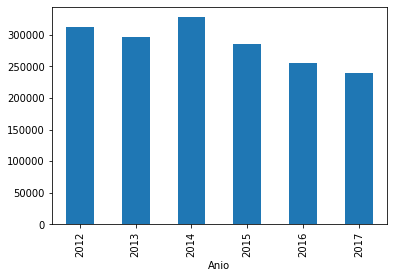

In [ ]:
#Se agrupan por años y se saca la suma de las unidades emitidas.
df.groupby('Anio').Unidades.sum().plot(kind='bar')

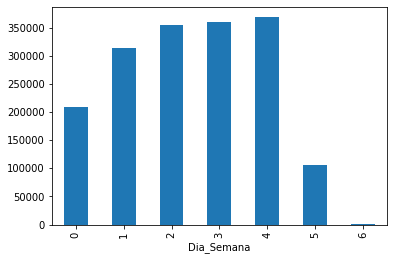

In [ ]:
#Se agrupan por dia de la semana y se saca la suma de las unidades emitidas.
df.groupby('Dia_Semana').Unidades.sum().plot(kind='bar')

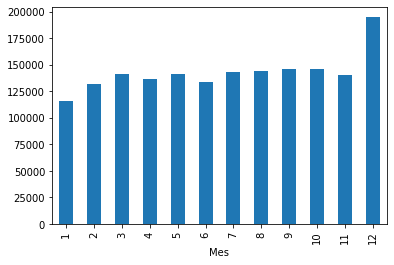

In [ ]:
#Se agrupan por mes y se saca la suma de las unidades emitidas.
df.groupby('Mes').Unidades.sum().plot(kind='bar')

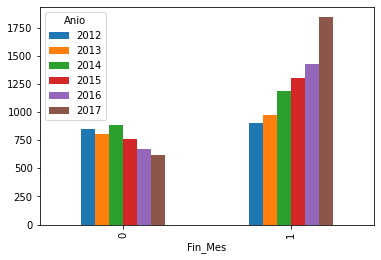

In [ ]:
#Se agrupa por si el dia es fin de mes o no, se segmenta por año y se suman 
#unidades totales emitidas.

df_pivot = pd.pivot_table(df, values='Unidades', index='Fin_Mes', columns='Anio',
                          aggfunc='mean')
df_pivot.plot(kind='bar')

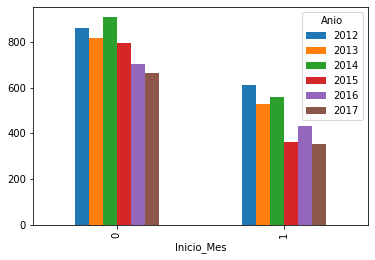

In [ ]:
#Se agrupa por si el dia es inicio de mes o no, se segmenta por año y se suman 
#unidades totales emitidas.

df_pivot = pd.pivot_table(df, values='Unidades', index='Inicio_Mes', columns='Anio',
                          aggfunc='mean')
df_pivot.plot(kind='bar')

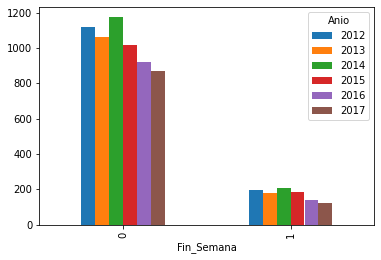

In [ ]:
#Se agrupa por si el dia es fin de semana o no, se segmenta por año y se suman 
#unidades totales emitidas.

df_pivot = pd.pivot_table(df, values='Unidades', index='Fin_Semana', columns='Anio',
                          aggfunc='mean')
df_pivot.plot(kind='bar')

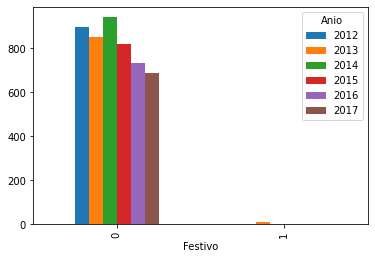

In [ ]:
#Se agrupa por si el dia es festivo o no, se segmenta por año y se suman 
#unidades totales emitidas.

df_pivot = pd.pivot_table(df, values='Unidades', index='Festivo', columns='Anio',
                          aggfunc='mean')
df_pivot.plot(kind='bar')

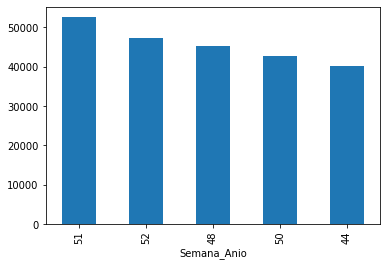

In [ ]:
#Se agrupan por semana del año y se saca la suma de las unidades emitidas, 
#al final tomamos solamente las 5 en donde mas hay emisiones .

df.groupby('Semana_Anio').Unidades.sum().sort_values(ascending=False)[0:5].plot(kind='bar')

## Conclusión

Al entrenar y probar los modelos escogidos, se descubrió que el modelo Bosque Aleatorio es el mejor modelo ya que predice valores positivos a comparación de los modelos de Regresión Lineal y Lasso; y tiene una menor variación en los R^2 entre entrenamiento y validación al ser comparado con la Red Neuronal y la Máquina de Soporte Vectorial, por lo que el mejor candidato es el modelo de Bosques Aleatorios y este será utilizado para hacer las debidas predicciones.

In [ ]:
df1 = df.drop(['Fecha', 'Unidades'], axis=1,  errors='ignore')
prediction_1 = RF_model.predict(df1)
df1['Prediccion'] = prediction_1
df1.to_csv(r'predicciones_2012-2017.txt', index=None, sep=' ', mode='a')

In [ ]:
df2 = df_2018.drop(['Fecha', 'Unidades', 'Prediccion_RF'], axis=1,  errors='ignore')
prediction_2 = RF_model.predict(df2)
df2['Prediccion'] = prediction_2
df2.to_csv(r'predicciones_2018.txt', index=None, sep=' ', mode='a')